In [1]:
pwd

'C:\\Users\\Nur Aiman\\Downloads'

In [15]:
import nltk
import pandas as pd
import numpy as np
import re
import sys
import csv
import itertools
import datetime
import matplotlib.pyplot as plt
import pprint
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
from nltk.tokenize import word_tokenize
from time import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score

In [20]:
train = pd.read_csv('train (1).csv', header=0, lineterminator='\n')
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')

# Removing empty rows from csv 
train.dropna(axis=0, how='all',inplace=True)
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty rows')

train.head()

There are 83 rows and 3 columns in the training set
There are 83 rows and 3 columns in the training set after removing empty rows


,ID,speech,label\r
0,006q1,Perasaan saya tiga hari ni rasa macam penat ra...,1
1,110q1,Sejujurnya saya berasa diri saya kosong saya t...,1
2,113q1,assalamualaikum saya 113. 3 hari lepas eh sepa...,1
3,136q1,Bismillahiroh Manirrohim Assalamualaikum wbt k...,1
4,139q1,Perasaan saya 3 hari ni saya malas nak buat ap...,1


In [21]:
test = pd.read_csv('test (1).csv', header=0, lineterminator='\n')
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set')

# Removing empty rows from csv 
test.dropna(axis=0, how='all',inplace=True)
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set after removing empty rows')

test.head()

There are 21 rows and 3 columns in the testing set
There are 21 rows and 3 columns in the testing set after removing empty rows


,ID,speech,label\r
0,212q,Okay apa yang bermain dalam fikiran saya sejak...,1
1,219q,Hari isnin lepas saya pergi ke hospital dan sa...,1
2,MH007Q,"Dalam 3 hari yang lepas, saya banyak meluangk...",0
3,MH008Q,"Dalam 3 hari lepas ni, saya banyak berada di r...",0
4,RokuraQ,Apa yang saya rasa sepanjang 3 hari yang lepas...,0


In [22]:
X_train = train.drop(['label\r','ID'],axis=1)
y_train = train['label\r']

X_test = test.drop(['label\r','ID'],axis=1)
y_test = test['label\r']

# X_test.head()

### NOISE CLEANING

In [23]:
import regex as re

X_train['speech'] = X_train['speech'].str.lower()
X_train['speech'] =X_train['speech'].apply(lambda x: re.sub('[^\w\d\s\']+', '', x))
X_train['speech'] = X_train['speech'].apply(lambda x: re.sub('\w*\d\w*', '', x))

X_test['speech'] = X_test['speech'].str.lower()
X_test['speech'] =X_test['speech'].apply(lambda x: re.sub('[^\w\d\s\']+', '', x))
X_test['speech'] = X_test['speech'].apply(lambda x: re.sub('\w*\d\w*', '', x))

X_test.head()

,speech
0,okay apa yang bermain dalam fikiran saya sejak...
1,hari isnin lepas saya pergi ke hospital dan sa...
2,dalam hari yang lepas saya banyak meluangkan...
3,dalam hari lepas ni saya banyak berada di rum...
4,apa yang saya rasa sepanjang hari yang lepas ...


### TOKENIZATION

In [24]:
X_train['speech_tokenize'] = X_train['speech'].apply(word_tokenize)
X_test['speech_tokenize'] = X_test['speech'].apply(word_tokenize)

X_train.head()

,speech,speech_tokenize
0,perasaan saya tiga hari ni rasa macam penat ra...,"[perasaan, saya, tiga, hari, ni, rasa, macam, ..."
1,sejujurnya saya berasa diri saya kosong saya t...,"[sejujurnya, saya, berasa, diri, saya, kosong,..."
2,assalamualaikum saya hari lepas eh sepanjang...,"[assalamualaikum, saya, hari, lepas, eh, sepan..."
3,bismillahiroh manirrohim assalamualaikum wbt k...,"[bismillahiroh, manirrohim, assalamualaikum, w..."
4,perasaan saya hari ni saya malas nak buat apa...,"[perasaan, saya, hari, ni, saya, malas, nak, b..."


### STOPWORDS

In [25]:
# initializing Stop words libraries

#nltk.download('stopwords')
#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
stop_words = {"yg","kita",'yang',"buat","kadang","boleh","dalam","jadi","jangan","jgn","dn","dan",
              "bismillahiroh","manirrohim","wbt","kod",                   
              "akan","dia","then","banyak","apa","okay","di","dah","je","tak","tu",
                                
              "so","haa","dengan","tak","pun","nak","lah","kan","and","kat","untuk","juga","dapat",
                                 
              "lah","to","ynag","yang","ada","ya","saya","hmm","ah","tu","macam","dan","hari","semua",
                                 
              "kami","kalau","dari","lagi","kerana","itu","ini","ke","snagat","sangat",
                                 
              "pasal","tetapi","apabila","ni","itu","seperti","erm","bagi","contoh","if",
                                 
              "ermm","tapi","ha","sebab","bila","that","rasa","my","of","i","from","ahh", "agak","aku","the",
                                
              "benda","memang","still","for","assalamualaikum","insyaAllah","insyaallah","nama", "eh",
                                
              "lepas","masa","orang","semua","balik","tiga","sekarang","pada","satu","tahu","daripada","sampai","pada",
                                 
              "diorang","mungkin","baru"}

In [26]:
#plotting words with highest count after removing stopwords
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=stop_words
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:100]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

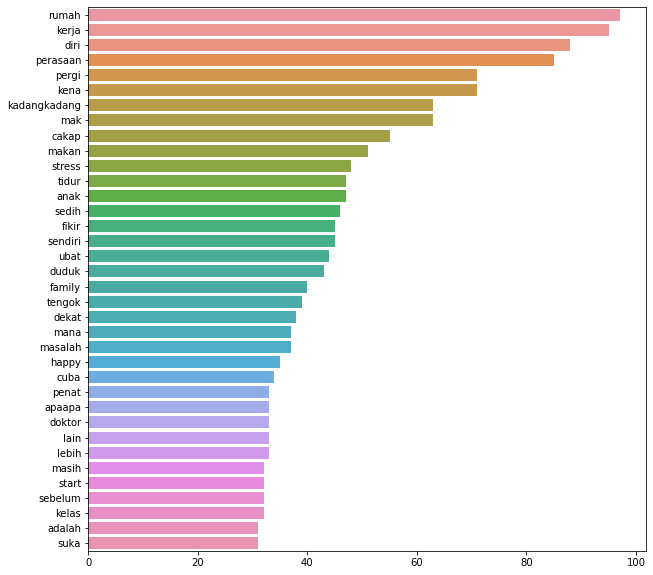

In [27]:
plot_top_non_stopwords_barchart(X_train['speech'])

In [29]:
# Now we remove stopwords 

X_train['speech_tokenize'] = X_train['speech_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
X_train['speech_tokenize_join'] = [' '.join(map(str, l)) for l in X_train['speech_tokenize']]

X_test['speech_tokenize'] = X_test['speech_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
X_test['speech_tokenize_join'] = [' '.join(map(str, l)) for l in X_test['speech_tokenize']]

X_train.head()

,speech,speech_tokenize,speech_tokenize_join
0,perasaan saya tiga hari ni rasa macam penat ra...,"[perasaan, penat, lethargic, hopeless, helples...",perasaan penat lethargic hopeless helpless hap...
1,sejujurnya saya berasa diri saya kosong saya t...,"[sejujurnya, berasa, diri, kosong, hala, tuju,...",sejujurnya berasa diri kosong hala tuju nampak...
2,assalamualaikum saya hari lepas eh sepanjang...,"[sepanjang, saat, mula, manabanyak, fikir, fik...",sepanjang saat mula manabanyak fikir fikir ker...
3,bismillahiroh manirrohim assalamualaikum wbt k...,"[telah, mula, bekerja, setelah, beberapa, bula...",telah mula bekerja setelah beberapa bulan pkp ...
4,perasaan saya hari ni saya malas nak buat apa...,"[perasaan, malas, apaapa, hampir, bulan, sorry...",perasaan malas apaapa hampir bulan sorrysorry ...


### TFIDF

In [73]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [97]:
data = pd.concat([X_train, X_test], axis=0)
data.shape

(104, 3)

In [99]:
# fit train data to the count vectorizer
data_counts = count_vectorizer.fit_transform(data['speech_tokenize_join'].values)

#fit the ngrams count to the tfidf transformers
data_tfidf = transformer.fit_transform(data_counts)

data_tfidf.shape

(104, 12659)

In [120]:
X_train_tfidf = data_tfidf[0:83] #train 83, test 21
X_test_tfidf = data_tfidf[83:104]
X_train_tfidf.shape

(83, 12659)

In [126]:
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train_tfidf, y_train)
Extr_predict = Extr.predict(X_test_tfidf)

Extr_cv_score = cross_val_score(Extr, X_train_tfidf, y_train, cv=10, scoring='roc_auc')
y_pred = Extr_predict
print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train_tfidf, y_train)))
print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test_tfidf, y_test)))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, Extr_predict))
print('\n') 
print("=== Classification Report ===")
print(classification_report(y_test, Extr_predict))
print('\n') 
print("=== All AUC Scores ===") 
print(Extr_cv_score)
print('\n') 
print("=== Mean AUC Score ===")
print("Mean AUC Score - svm: ", Extr_cv_score.mean())
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.57
=== Confusion Matrix ===
[[9 2]
 [7 3]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.60      0.30      0.40        10

    accuracy                           0.57        21
   macro avg       0.58      0.56      0.53        21
weighted avg       0.58      0.57      0.54        21



=== All AUC Scores ===
[0.975   0.925   0.825   0.625   0.8125  0.71875 0.71875 0.875   0.75
 0.96875]


=== Mean AUC Score ===
Mean AUC Score - svm:  0.819375
Accuracy:  0.5714285714285714


In [130]:
Adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train_tfidf, y_train)
Adab_predict = Adab.predict(X_test_tfidf)

# Adab_cv_score = cross_val_score(Adab, X_train_tfidf, y_train, cv=10, scoring='roc_auc')
y_pred = Adab_predict
print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Adab.score(X_train_tfidf, y_train)))
print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Adab.score(X_test_tfidf, y_test)))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, Adab_predict))
print('\n') 
print("=== Classification Report ===")
print(classification_report(y_test, Adab_predict))
# print('\n') 
# print("=== All AUC Scores ===") 
# print(Adab_cv_score)
# print('\n') 
# print("=== Mean AUC Score ===")
# print("Mean AUC Score - svm: ", Adab_cv_score.mean())
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.62
=== Confusion Matrix ===
[[10  1]
 [ 7  3]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.75      0.30      0.43        10

    accuracy                           0.62        21
   macro avg       0.67      0.60      0.57        21
weighted avg       0.67      0.62      0.58        21

Accuracy:  0.6190476190476191


In [131]:
RF= RandomForestClassifier(n_estimators=5)
RF.fit(X_train_tfidf, y_train)
RF_predict = RF.predict(X_test_tfidf)

RF_cv_score = cross_val_score(RF, X_train_tfidf, y_train, cv=10, scoring='roc_auc')
y_pred = RF_predict
print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(RF.score(X_train_tfidf, y_train)))
print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(RF.score(X_test_tfidf, y_test)))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, RF_predict))
print('\n') 
print("=== Classification Report ===")
print(classification_report(y_test, RF_predict))
print('\n') 
print("=== All AUC Scores ===") 
print(RF_cv_score)
print('\n') 
print("=== Mean AUC Score ===")
print("Mean AUC Score - svm: ", RF_cv_score.mean())
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy of ExtraTrees classifier on train set: 0.98
Accuracy of ExtraTrees classifier on test set: 0.67
=== Confusion Matrix ===
[[10  1]
 [ 6  4]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.80      0.40      0.53        10

    accuracy                           0.67        21
   macro avg       0.71      0.65      0.64        21
weighted avg       0.71      0.67      0.64        21



=== All AUC Scores ===
[0.825   0.825   0.925   0.8125  0.9375  0.8125  1.      0.90625 0.65625
 0.8125 ]


=== Mean AUC Score ===
Mean AUC Score - svm:  0.85125
Accuracy:  0.6666666666666666


In [134]:
NB = MultinomialNB()
NB.fit(X_train_tfidf, y_train)
NB_predict = NB.predict(X_test_tfidf)

NB_cv_score = cross_val_score(NB, X_train_tfidf, y_train, cv=10, scoring='roc_auc')
y_pred = NB_predict
print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(NB.score(X_train_tfidf, y_train)))
print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(NB.score(X_test_tfidf, y_test)))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, NB_predict))
print('\n') 
print("=== Classification Report ===")
print(classification_report(y_test, NB_predict))
print('\n') 
print("=== All AUC Scores ===") 
print(NB_cv_score)
print('\n') 
print("=== Mean AUC Score ===")
print("Mean AUC Score - svm: ", NB_cv_score.mean())
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.95
=== Confusion Matrix ===
[[11  0]
 [ 1  9]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.90      0.95        10

    accuracy                           0.95        21
   macro avg       0.96      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21



=== All AUC Scores ===
[0.9    0.95   1.     1.     1.     1.     1.     1.     0.9375 0.8125]


=== Mean AUC Score ===
Mean AUC Score - svm:  0.96
Accuracy:  0.9523809523809523


In [136]:
lr = LogisticRegression(C=1e5)
lr.fit(X_train_tfidf, y_train)
lr_predict = lr.predict(X_test_tfidf)

lr_cv_score = cross_val_score(lr, X_train_tfidf, y_train, cv=10, scoring='roc_auc')
y_pred = lr_predict
print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(lr.score(X_train_tfidf, y_train)))
print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(lr.score(X_test_tfidf, y_test)))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, lr_predict))
print('\n') 
print("=== Classification Report ===")
print(classification_report(y_test, lr_predict))
print('\n') 
print("=== All AUC Scores ===") 
print(lr_cv_score)
print('\n') 
print("=== Mean AUC Score ===")
print("Mean AUC Score - svm: ", lr_cv_score.mean())
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.86
=== Confusion Matrix ===
[[11  0]
 [ 3  7]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.70      0.82        10

    accuracy                           0.86        21
   macro avg       0.89      0.85      0.85        21
weighted avg       0.89      0.86      0.85        21



=== All AUC Scores ===
[0.8    0.95   1.     1.     1.     1.     1.     1.     0.9375 0.8125]


=== Mean AUC Score ===
Mean AUC Score - svm:  0.95
Accuracy:  0.8571428571428571


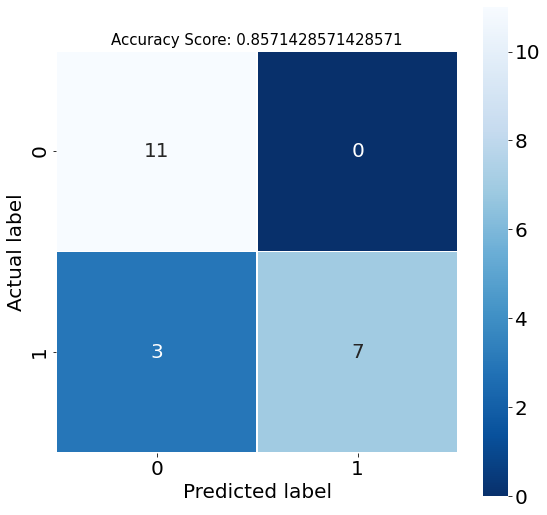

In [152]:
from sklearn import metrics

score = accuracy_score(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.rcParams.update({'font.size': 20})